In [2]:
import numpy as np
import h5py
import math
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [3]:
#import the crust (sly default)
crust = np.loadtxt("/Users/nanxiyao/Documents/grad/Research/NS_HIC/finiteT/eos.dat",unpack=True)

In [4]:
nsat = 0.16
hc=197.3
mN=938.0

#constants for construction of the NS EOS
rhosat = 0.8 #switch the crust to functional forms
dn = 0.005
mag = -0.5 #magnitude of the bump
width = 1 #width of the bump
off = 1.6  #center of the bump
size = int((50-rhosat)/dn) #size of the EOS list, 0<rho<50, drho = 0.005
ns1=1.5
ns2=1.6

In [5]:
def YQ(rho, E, L, K):
    x=(rho/nsat-1.0)/3.0
    power = (E+L*x+K*x*x/2)/hc
    yq = 64.0/3.0/(rho/nsat)/math.pi/math.pi/nsat*power*power*power
    if yq>1:
        return 1
    else:
        return yq

In [6]:
def e2E(e,rho):
    return e/rho-mN

def E2e(E,rho):
    return rho*(E+mN)
def getEHIC(eNS, rho, e0, L, K, J, Y_HIC):
    yq=YQ(rho, e0, L, K)
    delta = 1-2*yq
    expansion = e0+L*(rho/nsat-1)/3+K/18*(rho/nsat-1)*(rho/nsat-1)+J/162*(rho/nsat-1)*(rho/nsat-1)*(rho/nsat-1)
    return eNS-expansion*4*((Y_HIC-yq)+(yq*yq-Y_HIC*Y_HIC))

def getP(rho,eoverrho):
    func = interpolate.splrep(rho, eoverrho)
    ynew = interpolate.splev(rho, func, der=1)
    return np.multiply(ynew,np.multiply(rho,rho))

def interpolation(x,y,n):
    func = interpolate.splrep(x, y)
    ynew = interpolate.splev(x, func, der=n)
    return ynew

def getEden(nB, eNS, e0, L, K, J, Y_HIC):
    EHIC=[]
    EHIC=[getEHIC(e2E(y,x),x,e0,L,K,J,Y_HIC)for x, y in zip(nB, eNS)]
    eHIC=[E2e(y,x)for x, y in zip(nB,EHIC)]
    return eHIC

def getcs2(nB, eNS, e0, L, K, J,Y_HIC):
    eHIC=getEden(nB,eNS,e0,L,K,J,Y_HIC)
    eoverrho=np.divide(eHIC,nB)
    pressure=getP(nB,eoverrho)
    cs2=interpolation(eHIC,pressure,1)
    cs2_par=[cs2[i] for i in range(50,100)]
    cs2_par=gaussian_filter1d(cs2_par, sigma=6)
    for i in range(50,100):
        cs2[i]=cs2_par[i-50]
    return cs2

def interpolation_single(x,y,atx):
    tck = interpolate.splrep(x, y, s=0)
    xnew = atx
    ynew = interpolate.splev(atx, tck, der=0)
    return ynew.item()


##############functions needed to construct the EOS

def cs2low(atx):
    x = crust[0]
    y = crust[3]
    tck = interpolate.splrep(x, y, s=0)
    xnew = atx
    ynew = interpolate.splev(atx, tck, der=0)
    return ynew.item()

def bumpf(x):
    return 1/3-mag*math.exp(-(x-off)**2/(width**2))

def fx(x, f1, f2,ns1,ns2):
    x0 = (f2(ns2)-f1(ns1)+(ns1**2-ns2**2))/(2*(ns1-ns2))
    y0 = f2(ns2)-(ns2-x0)**2
    return (x-x0)**2+y0

def disbump(x):
    if x < ns1:
        return cs2low(x)
    elif x >= ns1 and x <= ns2:
        return fx(x, cs2low, bumpf, ns1, ns2)
    else:
        return bumpf(x)

def comblowden(crust, func, rhosat):
    #the crust part
    n1 = [nsat*crust[0][i] for i in range(len(crust[0])) if crust[0][i] < rhosat]
    e1 = [crust[2][i]for i in range(len(crust[0])) if crust[0][i] < rhosat]
    p1 = [crust[1][i]for i in range(len(crust[0])) if crust[0][i] < rhosat]
    cs21=[func(n1[i]) for i in range(len(n1))]
    muB1=[(p1[i]+e1[i])/(nsat*n1[i]) for i in range(len(n1))]
    #then construct the functional form(a bump)
    e0=interpolation_single(crust[0],crust[2],rhosat)
    p0=interpolation_single(crust[0],crust[1],rhosat)
    n2=[0 for x in range(size)]
    e2=[0 for x in range(size)]
    p2=[0 for x in range(size)]
    cs22=[0 for x in range(size)]
    muB2=[0 for x in range(size)]
    e2[0]=e0
    p2[0]=p0
    n2[0]=rhosat
    dn=0.005
    for i in range(1,size):
        n2[i]=n2[0]+i*dn
        e2[i]=e2[i-1]+dn*(e2[i-1]+p2[i-1])/n2[i-1]
        p2[i]=p2[i-1]+func(n2[i-1])*dn*(e2[i-1]+p2[i-1])/n2[i-1]
        cs22[i]=func(n2[i])
        muB2[i] = (p2[i]+e2[i])/(nsat*n2[i])
    for i in range(0,size):
        n2[i]=n2[i]*nsat
    n1.extend(n2)   
    e1.extend(e2)
    p1.extend(p2)
    cs21.extend(cs22)
    muB1.extend(muB2)
    EOS = [n1,p1,e1,cs21,muB1]
    return EOS

In [7]:
EOS=comblowden(crust, disbump, rhosat)
#print(EOS[2])


#tab = np.loadtxt("/Users/nanxiyao/Documents/grad/Research/NS_HIC/finiteT/eos1.dat",unpack=True)
tab=EOS
nB=np.asarray(tab[0][:1000])
eNS=np.asarray(tab[2][:1000])
oriP=np.asarray(tab[1][:1000])


[0.11361996 0.13160667 0.17157832 0.2057212  0.24148974 0.27688594
 0.31244535 0.34802442 0.38366162 0.41934663 0.45508225 0.49086766
 0.52670328 0.56258829 0.59852556 0.63450438 0.67056476 0.70655724
 0.74304022 0.77792738 0.81901401 0.83717252 0.83227567 0.83353277
 0.83310711 0.83310124 0.83295108 0.83280799 0.83263139 0.83243221]
[1.5   1.505 1.51  1.515 1.52  1.525 1.53  1.535 1.54  1.545 1.55  1.555
 1.56  1.565 1.57  1.575 1.58  1.585 1.59  1.595 1.6   1.605 1.61  1.615
 1.62  1.625 1.63  1.635 1.64  1.645]


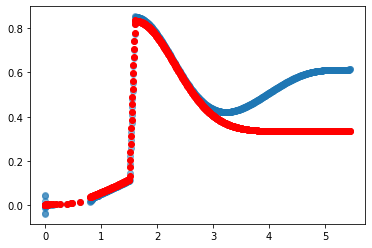

In [29]:
#produce a single cs2 to check, not necessary for the YQ slices
y=getcs2(nB,eNS,31,57,-100,0,0.38)
cs2NS=interpolation(eNS,oriP,1)
dSdT=3
print(cs2NS[210:240])
print(nB[210:240]/nsat)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(nB/nsat, y,alpha=0.5)
ax1.scatter(nB/nsat,cs2NS,c='r')
plt.show()

In [30]:
w,h=1000,60
MeVfm3togcm3 = 1.7827*(10**12)
internal_Energy = [[0 for x in range(w)] for y in range(h)] 
cs2 = [[0 for x in range(w)] for y in range(h)] 
pressure_HIC=[[0 for x in range(w)] for y in range(h)] 
nbgcm3 = [x*MeVfm3togcm3 for x in nB]
mue = [[0 for x in range(w)] for y in range(h)] 
mup = [[0 for x in range(w)] for y in range(h)] 
mun = [[0 for x in range(w)] for y in range(h)] 
temp = [0.01+i*0.8333 for i in range(180)]
logtemp = [temp[i] for i in range(len(temp))]
#getting different YQ slices, 60 points for YQ
for i in range(0,60):
    Y_HIC=0.01+i*0.00816
    internal_Energy[i]=getEden(nB,eNS,31,57,-100,0,Y_HIC)
    eoverrho=np.divide(internal_Energy[i],nB)
    pressure_HIC[i]=getP(nB,eoverrho)
    cs2[i]=interpolation(internal_Energy[i],pressure_HIC[i],1)
    mue[i]=interpolation(nB*Y_HIC, internal_Energy[i],1)
    mup[i]=mue[i]
    mun[i]=interpolation(nB*(1-Y_HIC),internal_Energy[i],1)
#add temperature axis for pressure    
pressure = [[[0 for x in range(w)]for y in range(h)]for z in range(len(temp))]

for i in range(len(temp)):
    for j in range(h):
        for k in range(w):
            pressure[i][j][k]=pressure_HIC[j][k]+1/2*dSdT*temp[i]

In [31]:
with h5py.File('/Users/nanxiyao/Documents/grad/Research/NS_HIC/finiteT/hdf5_data.h5','w') as hdf:
    hdf.create_dataset('E',data=internal_Energy)
    hdf.create_dataset('cs2',data=cs2)
    hdf.create_dataset('nB',data=nbgcm3)
    hdf.create_dataset('pressure',data=pressure)
    hdf.create_dataset('mue',data=mue)
    hdf.create_dataset('mup',data=mup)
    hdf.create_dataset('mun',data=mun)
    hdf.create_dataset('logT',data=logtemp)